*Лабораторная работа № 1*

Ольшанов Александр Евгеньевич, группа 2374

1. Подготовка данных и анализ


In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


#берём описание файлов с метками
train_df = pd.read_csv('FSDKaggle2018.meta/train_post_competition.csv')
test_df = pd.read_csv('FSDKaggle2018.meta/test_post_competition_scoring_clips.csv')


#Количество уникальных меток в датасете теста + примеры
print(f"\nУникальные метки: {train_df['label'].nunique()}")
print(train_df['label'].value_counts().head(10))



Уникальные метки: 41
label
Hi-hat             300
Saxophone          300
Trumpet            300
Cello              300
Clarinet           300
Tearing            300
Fart               300
Laughter           300
Snare_drum         300
Acoustic_guitar    300
Name: count, dtype: int64


2. Извлечение признаков (мел-спектрограмма)

Извлекаем, далее преобразовываем в 2d-изображения. Это нужно для CNN-моделей, котоыре работают с изображенями.

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm

# Загрузка данных
train_df = pd.read_csv('FSDKaggle2018.meta/train_post_competition.csv')

# Параметры
SAMPLE_RATE = 22050
DURATION = 2.0
N_MELS = 128
FIXED_TIME_STEPS = int((SAMPLE_RATE * DURATION) / 512) + 1

def extract_log_mel_spectrogram(file_path, sr=SAMPLE_RATE, duration=DURATION, n_mels=N_MELS):
    # Загружаем аудио
    audio, sr = librosa.load(file_path, sr=sr, duration=duration)
    
    # Нужны одного размера => дополняем нулями
    if len(audio) < int(sr * duration):
        audio = np.pad(audio, (0, int(sr * duration) - len(audio)))
    
    # Извлекаем мел-спектрограмму
    mel_spec = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr, 
        n_mels=n_mels,
        n_fft=2048,
        hop_length=512
    )
    
    # Преобразуем в логарифмическую шкалу
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Обрезаем или дополняем до фиксированного размера
    if log_mel_spec.shape[1] < FIXED_TIME_STEPS:
        pad_width = FIXED_TIME_STEPS - log_mel_spec.shape[1]
        log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')
    else:
        log_mel_spec = log_mel_spec[:, :FIXED_TIME_STEPS]
    
    return log_mel_spec

# Извлекаем признаки для всех файлов
features = []
labels = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    file_path = os.path.join('FSDKaggle2018.audio_train', row['fname'])
    
    # Извлекаем лог-мел-спектрограмму
    log_mel = extract_log_mel_spectrogram(file_path)
    
    # Добавляем в список
    features.append(log_mel)
    labels.append(row['label'])

# Преобразуем в numpy массивы
X = np.array(features)  
y = np.array(labels)    

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

100%|██████████| 9473/9473 [03:21<00:00, 47.04it/s]


X shape: (9473, 128, 87)
y shape: (9473,)


Визуализируем первые 5 извлеченных спектрограмм


Спектрограмма 1: 00044347.wav
Метка: Hi-hat
Размер: (128, 87)


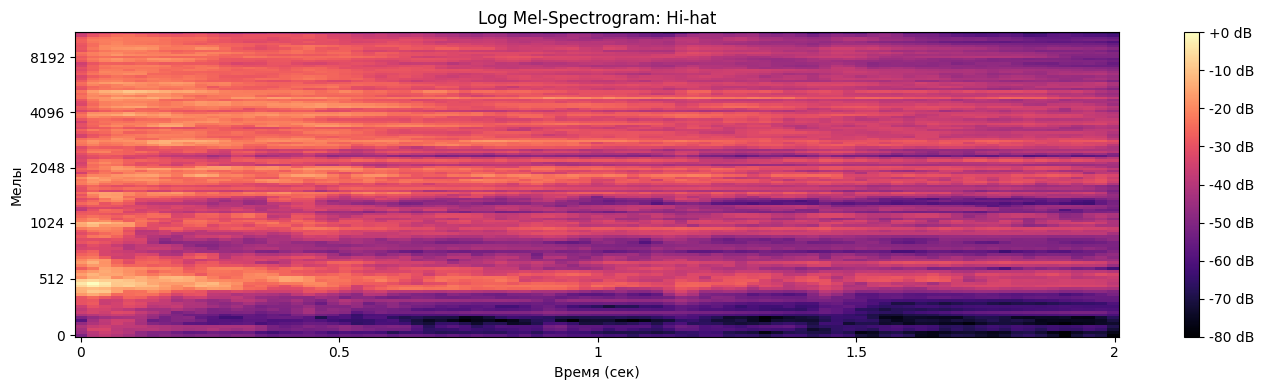


Спектрограмма 2: 001ca53d.wav
Метка: Saxophone
Размер: (128, 87)


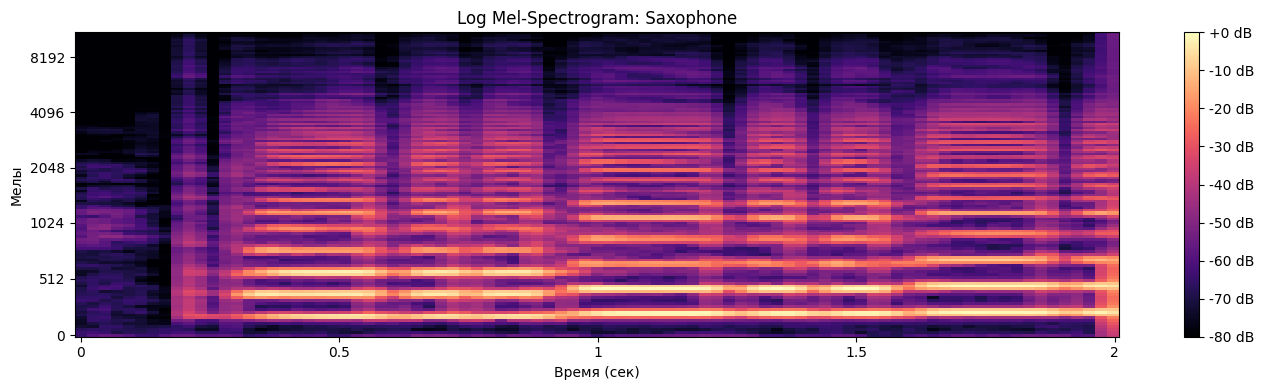


Спектрограмма 3: 002d256b.wav
Метка: Trumpet
Размер: (128, 87)


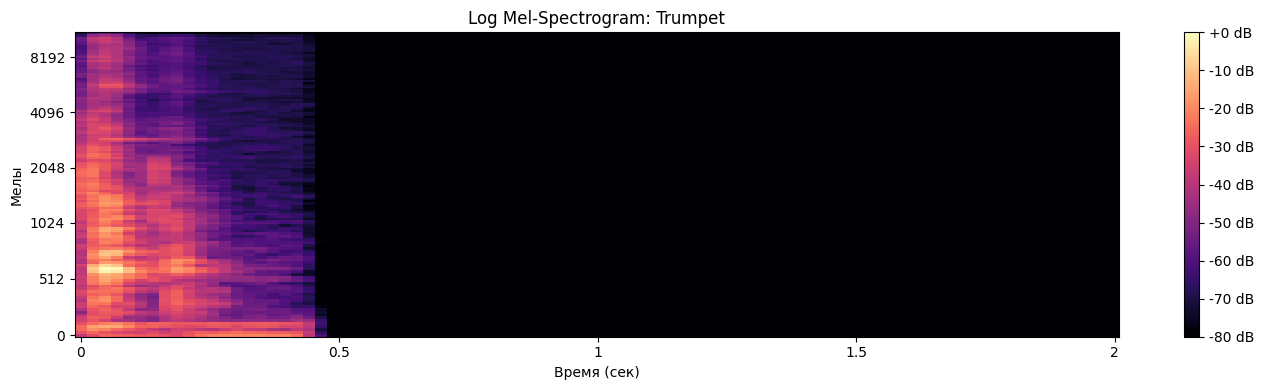


Спектрограмма 4: 0033e230.wav
Метка: Glockenspiel
Размер: (128, 87)


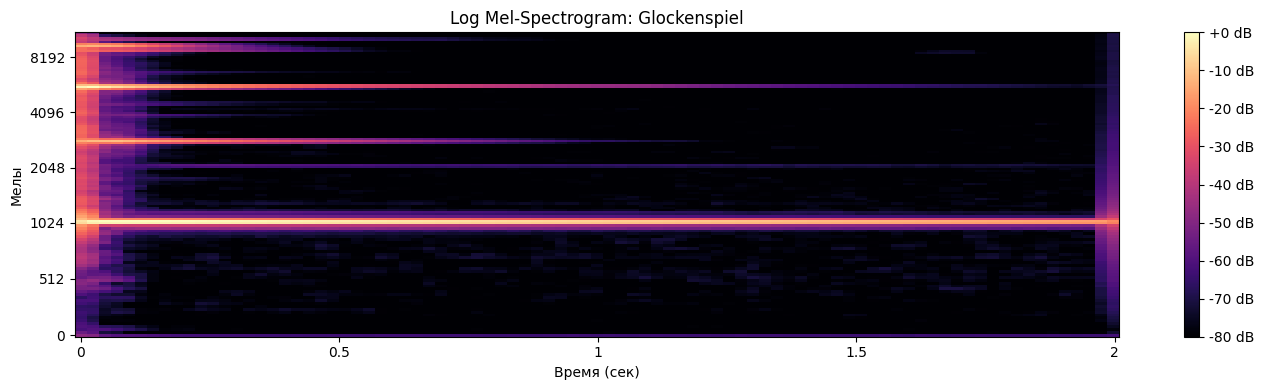


Спектрограмма 5: 00353774.wav
Метка: Cello
Размер: (128, 87)


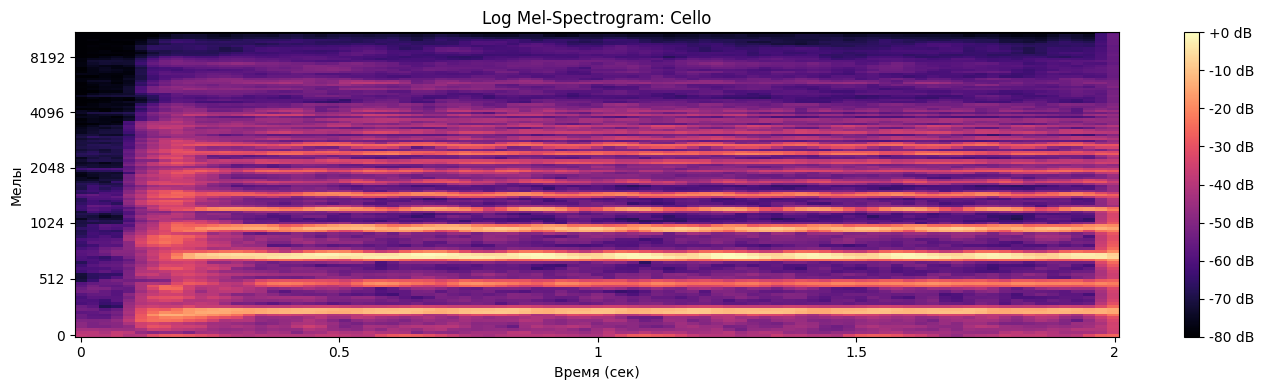

In [ ]:
# Визуализация уже извлеченных спектрограмм
def visualize_log_mel_spectrogram(spectrogram, label, sample_rate=22050):
    """Визуализация лог-мел-спектрограммы"""
    plt.figure(figsize=(14, 4))
    
    # specshow для отображения
    librosa.display.specshow(
        spectrogram, 
        x_axis='time',
        y_axis='mel',
        sr=sample_rate,
        hop_length=512
    )
    
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Log Mel-Spectrogram: {label}')
    plt.xlabel('Время (сек)')
    plt.ylabel('Мелы')
    plt.tight_layout()
    plt.show()

for i in range(5):
    print(f"\nСпектрограмма {i+1}: {train_df.iloc[i]['fname']}")
    print(f"Метка: {train_df.iloc[i]['label']}")
    print(f"Размер: {X[i].shape}")
    
    visualize_log_mel_spectrogram(X[i], train_df.iloc[i]['label'])

3. Разделение на обучающую и валидационную выборки

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Кодируем текстовые метки в числа (дальше понадобится)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

print(f"Количество классов: {num_classes}")
print(f"Пример кодирования: {label_encoder.classes_[:5]} -> {label_encoder.transform(label_encoder.classes_[:5])}")

# Разделяем обучающий набор на тренировочную и тестовыую части
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded  # балансирователь
)

print(f"\nРазделение данных:")
print(f"Обучающая выборка (X_train): {X_train.shape}")
print(f"Валидационная выборка (X_val): {X_val.shape}")
print(f"Обучающие метки (y_train): {y_train.shape}")
print(f"Валидационные метки (y_val): {y_val.shape}")
print(f"Пропорция: {len(X_train)}/{len(X_val)} = {len(X_train)/len(X):.1%}/{len(X_val)/len(X):.1%}")

# Подготовим тестовый набор для финальной оценки
test_df = pd.read_csv('FSDKaggle2018.meta/test_post_competition_scoring_clips.csv')

test_features = []
test_labels = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = os.path.join('FSDKaggle2018.audio_test', row['fname'])
    
    log_mel = extract_log_mel_spectrogram(file_path)
    
    test_features.append(log_mel)
    test_labels.append(row['label'])

# Преобразуем в numpy
X_test = np.array(test_features)
y_test_text = np.array(test_labels)

y_test = label_encoder.transform(y_test_text)

print(f"\nТестовый набор:")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Количество классов: 41
Пример кодирования: ['Acoustic_guitar' 'Applause' 'Bark' 'Bass_drum' 'Burping_or_eructation'] -> [0 1 2 3 4]

Разделение данных:
Обучающая выборка (X_train): (7578, 128, 87)
Валидационная выборка (X_val): (1895, 128, 87)
Обучающие метки (y_train): (7578,)
Валидационные метки (y_val): (1895,)
Пропорция: 7578/1895 = 80.0%/20.0%


100%|██████████| 1600/1600 [00:47<00:00, 34.03it/s]



Тестовый набор:
X_test: (1600, 128, 87)
y_test: (1600,)


4. Создание и обучение модели


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


# Добавляем размерность каналов к данным
X = X[..., np.newaxis] 
print(f"X shape после добавления каналов: {X.shape}")

# Разделяем снова
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Кодируем метки
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# One-hot encoding
y_onehot = to_categorical(y_encoded, num_classes=num_classes)

# Разделяем
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y_onehot, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

print(f"\nРазделение данных:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

# Создаем модель
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Создаем модель
input_shape = X_train.shape[1:]  # (128, 87, 1)
model = create_cnn_model(input_shape, num_classes)

# Компилируем
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nМодель создана успешно!")

X shape после добавления каналов: (9473, 128, 87, 1)

Разделение данных:
X_train: (7578, 128, 87, 1)
X_val: (1895, 128, 87, 1)
y_train: (7578, 41)
y_val: (1895, 41)

Модель создана успешно!


Обучение модели

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Callbacks для улучшения обучения
callbacks = [
    EarlyStopping(
        monitor='val_loss',     
        patience=10,           
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',     
        factor=0.5,             
        patience=5,             
        min_lr=0.00001          
    )
]

print("\nНачинаем обучение CNN модели...")
print(f"Количество эпох: 10")
print(f"Размер батча: 16")
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_val)}")

# Запускаем обучение
history = model.fit(
    X_train, y_train,
    epochs=15,               
    batch_size=16,              
    validation_data=(X_val, y_val), 
    callbacks=callbacks,        
    verbose=1                   
)


Начинаем обучение CNN модели...
Количество эпох: 10
Размер батча: 16
Размер обучающей выборки: 7578
Размер валидационной выборки: 1895
Epoch 1/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 258s 527ms/step - accuracy: 0.1301 - loss: 3.5665 - val_accuracy: 0.1736 - val_loss: 3.0216 - learning_rate: 0.0010
Epoch 2/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 248s 522ms/step - accuracy: 0.2193 - loss: 2.8730 - val_accuracy: 0.2939 - val_loss: 2.4741 - learning_rate: 0.0010
Epoch 3/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 245s 516ms/step - accuracy: 0.2652 - loss: 2.6225 - val_accuracy: 0.3420 - val_loss: 2.7402 - learning_rate: 0.0010
Epoch 4/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 245s 516ms/step - accuracy: 0.3220 - loss: 2.4162 - val_accuracy: 0.3931 - val_loss: 2.2113 - learning_rate: 0.0010
Epoch 5/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 244s 514ms/step - accuracy: 0.3665 - loss: 2.2476 - val_accuracy: 0.4491 - val_loss: 2.0238 - learning_rate: 0.0010
Epoch 6/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 244s 514ms/step - accuracy: 0.4140 - loss: 2

15 поколений с 16 - размером батча - на мойм устройстве отработало на 1 час и 1 минуту

In [ ]:
# Оценка модели на валидационной выборке
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"финальные результаты на валидации:")
print(f"Точность: {val_acc:.4f} ({val_acc*100:.1f}%)")
print(f"Потери: {val_loss:.4f}")

финальные результаты на валидации:
Точность: 0.6084 (60.8%)
Потери: 1.3699


In [ ]:
# Предсказания на тестовых данных
print("предсказание для тестового набора (audio_test/)")

# Загрузка тестовых метаданных
test_df = pd.read_csv('FSDKaggle2018.meta/test_post_competition_scoring_clips.csv')

# Функция для обработки тестовых данных
def prepare_test_data(test_df):
    test_features = []
    
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
        file_path = os.path.join('FSDKaggle2018.audio_test', row['fname'])
        
        # Используем ту же функцию для извлечения признаков
        log_mel = extract_log_mel_spectrogram(file_path)
        
        log_mel = np.expand_dims(log_mel, axis=-1)
        
        test_features.append(log_mel)
    
    return np.array(test_features)

# Извлекаем признаки для тестового cета
print("Извлечение признаков для тестового набора")
X_test = prepare_test_data(test_df)
print(f"Тестовые данные: {X_test.shape}")


предсказание для тестового набора (audio_test/)
Извлечение признаков для тестового набора


100%|██████████| 1600/1600 [00:52<00:00, 30.75it/s]


Тестовые данные: (1600, 128, 87, 1)


In [ ]:
#предсказания
test_predictions = model.predict(X_test, batch_size=32, verbose=1)

# Подготовка результатов
def get_top_3_predictions(predictions, label_encoder):
    """Возвращает топ-3 предсказанных меток для каждого примера"""
    top_3_indices = np.argsort(predictions, axis=1)[:, -3:][:, ::-1]
    top_3_labels = label_encoder.inverse_transform(top_3_indices.flatten())
    top_3_labels = top_3_labels.reshape(predictions.shape[0], 3)
    return top_3_labels

# топ 3 предсказания
top_3_labels = get_top_3_predictions(test_predictions, label_encoder)


Делаем предсказания...
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step


In [ ]:
# Сохранение результатов
results_df = pd.DataFrame({
    'fname': test_df['fname'],
    'label_1': top_3_labels[:, 0],
    'label_2': top_3_labels[:, 1],
    'label_3': top_3_labels[:, 2]
})

results_df['labels'] = results_df.apply(
    lambda row: f"{row['label_1']} {row['label_2']} {row['label_3']}", 
    axis=1
)

# Сохраняем в нужном формате
submission_df = results_df[['fname', 'labels']]
submission_df.to_csv('submission.csv', index=False)

print(f"Файл: submission.csv")
print(f"Количество предсказаний: {len(submission_df)}")
print("\nПервые 5 предсказаний:")
print(submission_df.head())
print("\n" + "="*50)

Файл: submission.csv
Количество предсказаний: 1600

Первые 5 предсказаний:
          fname                         labels
0  00326aa9.wav            Oboe Clarinet Flute
1  0038a046.wav    Bass_drum Knock Double_bass
2  007759c4.wav    Flute Bark Violin_or_fiddle
3  008afd93.wav       Flute Saxophone Clarinet
4  00ae03f6.wav  Chime Keys_jangling Telephone



In [ ]:
def map_at_3(y_true, y_pred_top3):
    scores = []
    
    for true, preds in zip(y_true, y_pred_top3):
        score = 0
        correct = 0
        
        for k in range(3):
            if preds[k] == true:
                correct += 1
                score += correct / (k + 1)
        
        if correct > 0:
            scores.append(score / min(correct, 3))
        else:
            scores.append(0)
    
    return np.mean(scores)


# Вероятности предсказаний
pred_probs = model.predict(X_val, verbose=0)

# Топ-3 предсказанных индексов
top3_idx = np.argsort(pred_probs, axis=1)[:, -3:][:, ::-1]

# из индекса в метку
top3_labels = label_encoder.inverse_transform(top3_idx.reshape(-1))
top3_labels = top3_labels.reshape(-1, 3)

# y_val в текстовые метки
y_val_text = label_encoder.inverse_transform(np.argmax(y_val, axis=1))


map_score = map_at_3(y_val_text, top3_labels)
print(f"MAP@3 = {map_score:.4f} ({map_score*100:.2f}%)")

MAP@3 = 0.6922 (69.22%)


69.22% - округление в сторону студента до 70% мне кажется)